In [29]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
print(f"Using device: {device}")

Using device: cuda


In [30]:
def fourier_residual(t, theta):
    """
    Compute the residual f_theta(t) for the Fourier series ansatz:
    x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²
    with parameters theta = (ω, α, β, γ)
    """
    omega, alpha, beta, gamma = theta

    sin_omega = torch.sin(omega * t)
    sin_2omega = torch.sin(2 * omega * t) 
    sin_3omega = torch.sin(3 * omega * t)
    
    x_t = alpha * sin_omega**2 + beta * sin_2omega**2 + gamma * sin_3omega**2

    factor1 = x_t - 1.0
    term_sin2 = sin_omega**2
    term_sin4 = sin_omega**4
    term_sin2_3 = sin_3omega**2

    factor2 = (2 * alpha * term_sin2 - alpha
               - 32 * beta * term_sin4 + 32 * beta * term_sin2 - 4 * beta
               + 18 * gamma * term_sin2_3 - 9 * gamma)

    f_t = 2 * omega**2 * factor1 * factor2 + x_t - x_t**2
    return f_t

def optimize_theta_for_k(k_val, N=100, n_iter=1000, lr=1e-2, print_every=500):
    """
    Optimize Fourier series parameters theta = (omega, alpha, beta, gamma)
    for given K value to minimize squared error
    """
    t_points = torch.linspace(0, 5 * np.pi, N, device=device)
    
    theta = torch.tensor([1.0, k_val, k_val/2, k_val/4], device=device, requires_grad=True)
    
    optimizer = optim.Adam([theta], lr=lr)
    
    best_loss = float('inf')
    best_theta = None
    
    for it in range(n_iter):
        optimizer.zero_grad()
        f_vals = fourier_residual(t_points, theta)
        loss = torch.mean((f_vals - k_val)**2)
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_theta = theta.detach().clone()
        
        if (it+1) % print_every == 0:
            print(f"[K = {k_val:.3f}] Iter {it+1:4d}: loss = {loss.item():.4e}   theta = {theta.data.cpu().numpy()}")
    
    return best_theta, best_loss

k_example = 0.1
best_theta, best_loss = optimize_theta_for_k(k_example)

[K = 0.100] Iter  500: loss = 1.4472e-08   theta = [ 4.67141807e-01  2.26781286e-01  6.77833017e-04 -1.23910163e-05]
[K = 0.100] Iter 1000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]


In [31]:
# Compare Fourier series model with a Runge-Kutta solution

def runge_kutta_ode(k, dt=1e-6, T=5*np.pi):
    """
    Solve the original ODE using RK4:
    (1-x) x'' - x² + x = k
    
    Initial conditions: x(0)=0, x'(0)=0
    """
    N_steps = int(T / dt) + 1
    t = np.linspace(0, T, N_steps)
    x = np.zeros(N_steps)
    v = np.zeros(N_steps)  # velocity = x'
    
    def f(x, v):
        denom = 1 - x
        if np.abs(denom) < 1e-8:
            denom = np.sign(denom)*1e-8
        return (k + x**2 - x) / denom
    
    for i in range(N_steps-1):
        k1x = v[i]
        k1v = f(x[i], v[i])
        
        k2x = v[i] + 0.5 * dt * k1v
        k2v = f(x[i] + 0.5 * dt * k1x, v[i] + 0.5 * dt * k1v)
        
        k3x = v[i] + 0.5 * dt * k2v
        k3v = f(x[i] + 0.5 * dt * k2x, v[i] + 0.5 * dt * k2v)
        
        k4x = v[i] + dt * k3v
        k4v = f(x[i] + dt * k3x, v[i] + dt * k3v)
        
        x[i+1] = x[i] + dt/6 * (k1x + 2*k2x + 2*k3x + k4x)
        v[i+1] = v[i] + dt/6 * (k1v + 2*k2v + 2*k3v + k4v)
        
    return t, x

def fourier_series_solution(t, theta):
    """
    Compute Fourier series x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²
    """
    omega, alpha, beta, gamma = theta
    return (alpha * torch.sin(omega * t)**2 +
            beta * torch.sin(2 * omega * t)**2 +
            gamma * torch.sin(3 * omega * t)**2)

[K = 0.150] Iter 1000: loss = 6.5106e-10   theta = [ 4.36490042e-01  3.76551960e-01  4.60754459e-03 -1.56429543e-04]
[K = 0.150] Iter 2000: loss = 6.5106e-10   theta = [ 4.36489995e-01  3.76551981e-01  4.60755735e-03 -1.56430523e-04]
[K = 0.100] Iter 1000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]
[K = 0.100] Iter 2000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]
[K = 0.050] Iter 1000: loss = 1.5793e-15   theta = [ 4.85832520e-01  1.05689634e-01  5.81989578e-05 -5.83741239e-07]
[K = 0.050] Iter 2000: loss = 1.5793e-15   theta = [ 4.85832520e-01  1.05689634e-01  5.81989578e-05 -5.83741239e-07]


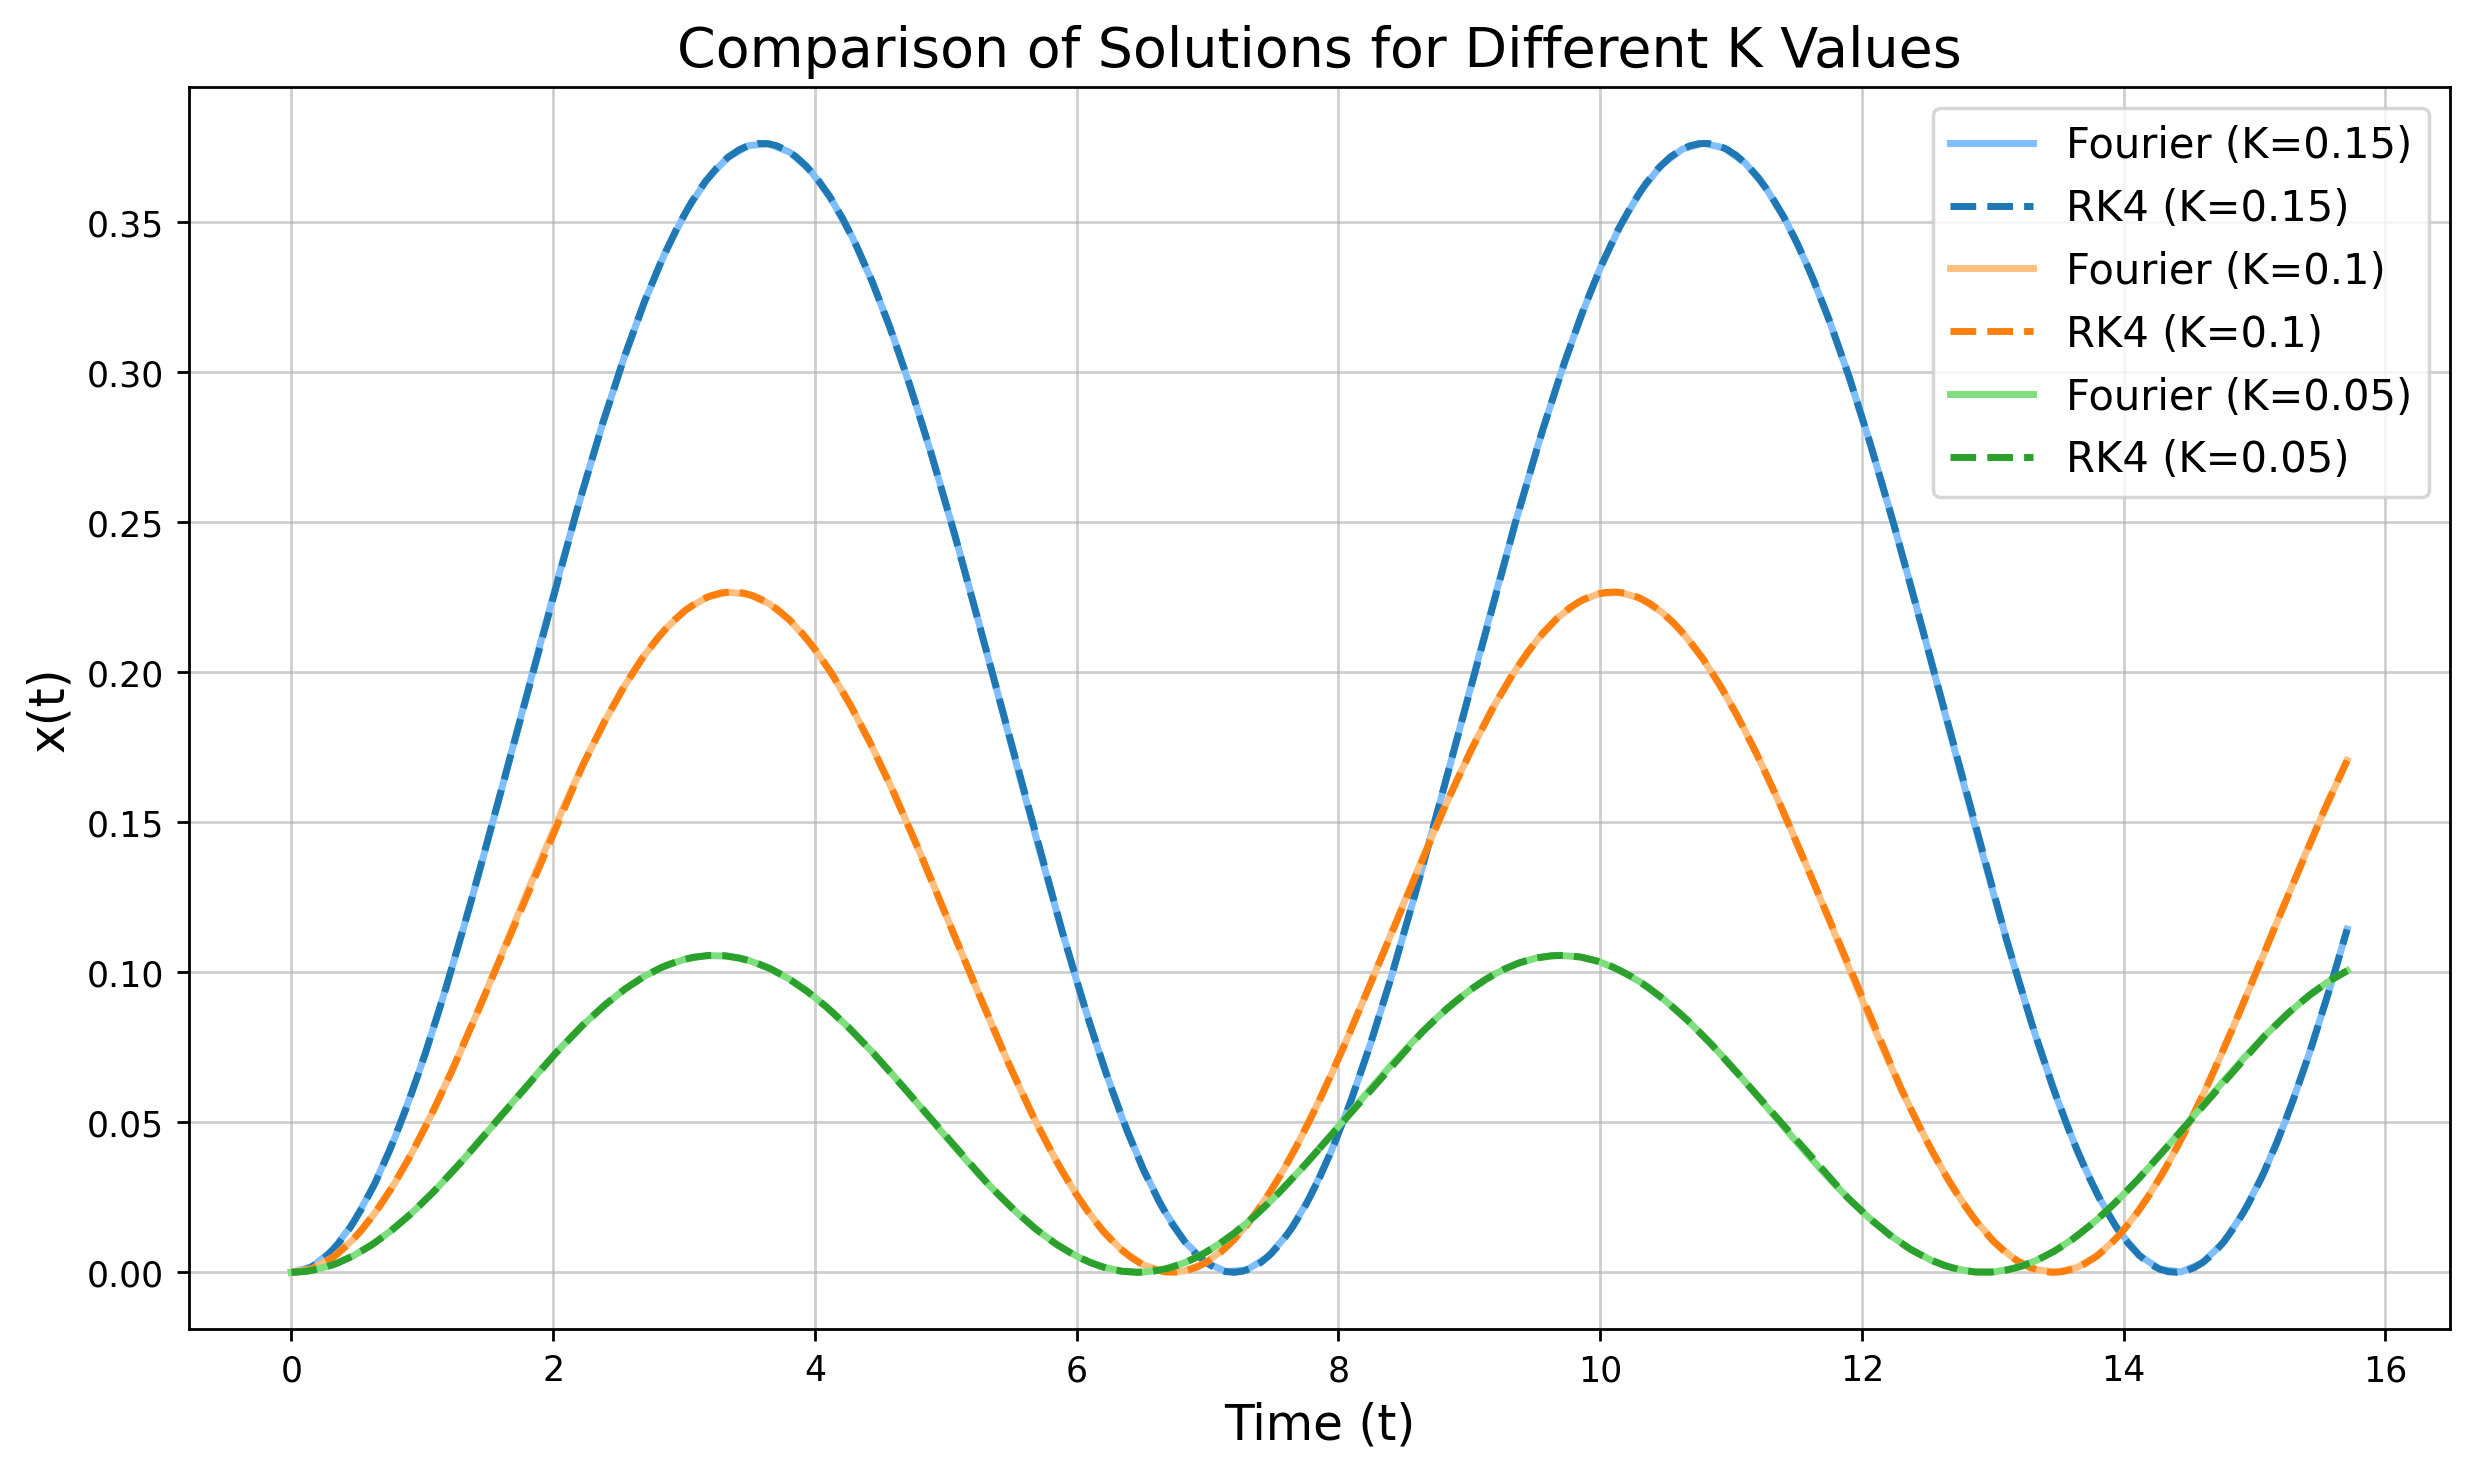

In [32]:
# Define K values to compare
k_values = [0.15, 0.1, 0.05]

# Store results for comparison plots
results = {'k_values': k_values, 't_rk': [], 'x_rk': [], 't_fourier': [], 'x_fourier': []}

plt.figure(figsize=(10, 6), dpi=250)

# Colors for plotting
light_colors = ['#7fbfff', '#ffbf7f', '#7fdf7f']  # Lighter versions
normal_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Standard colors

for i, k in enumerate(k_values):
    # RK4 solution
    t_rk, x_rk = runge_kutta_ode(k, dt=1e-5, T=5*np.pi)
    results['t_rk'].append(t_rk)
    results['x_rk'].append(x_rk)
    
    # Fourier solution
    best_theta, _ = optimize_theta_for_k(k, n_iter=2000, print_every=1000)
    t_fourier = torch.linspace(0, 5 * np.pi, 100, device=device)
    x_fourier = fourier_series_solution(t_fourier, best_theta).detach().cpu().numpy()
    results['t_fourier'].append(t_fourier.cpu().numpy())
    results['x_fourier'].append(x_fourier)
    
    plt.plot(t_fourier.cpu().numpy(), x_fourier, '-', linewidth=2,
             color=light_colors[i], label=f'Fourier (K={k})')
    plt.plot(t_rk[::100], x_rk[::100], '--', linewidth=2,
             color=normal_colors[i], label=f'RK4 (K={k})')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('x(t)', fontsize=14)
plt.title('Comparison of Solutions for Different K Values', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig('figs/comparison_multiple_k.pdf', bbox_inches='tight', dpi=300)
plt.show()

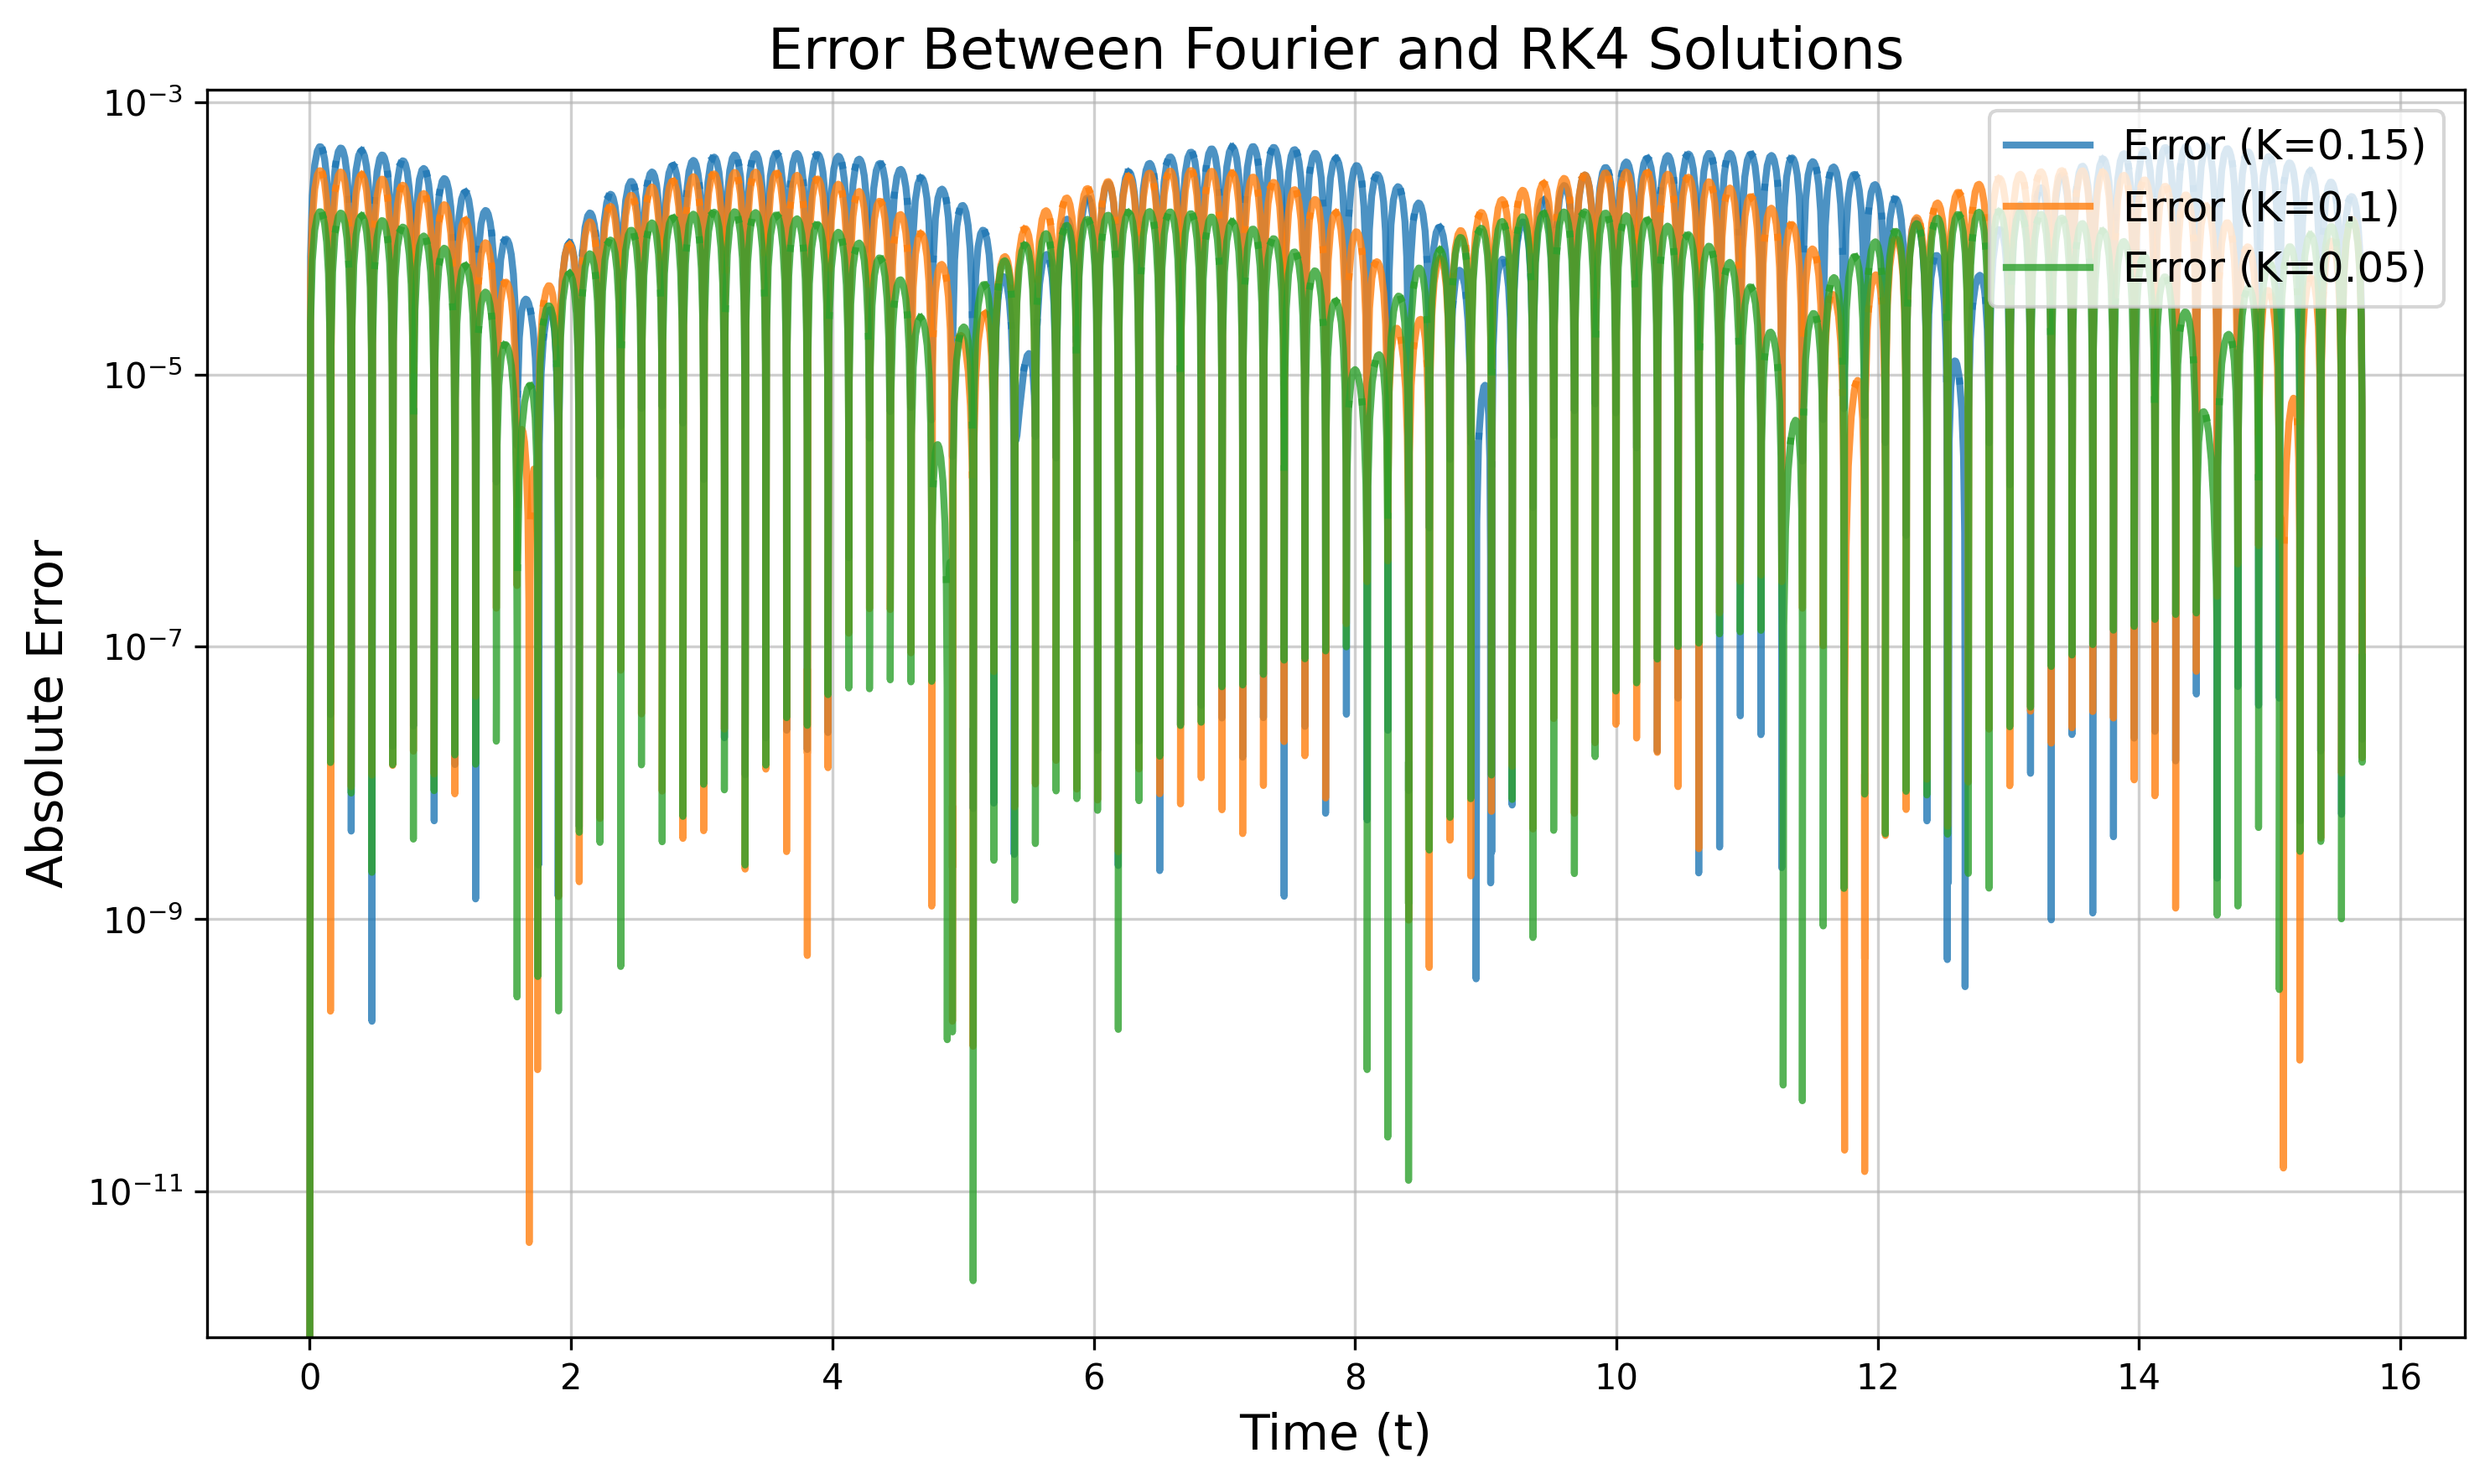

In [33]:
# Plot absolute error between Fourier and RK4 solutions
plt.figure(figsize=(10, 6), dpi=300)

for i, k in enumerate(k_values):
    x_fourier_interp = np.interp(results['t_rk'][i], results['t_fourier'][i], results['x_fourier'][i])
    error = np.abs(results['x_rk'][i] - x_fourier_interp)
    plt.plot(results['t_rk'][i], error, '-', linewidth=2,
             color=normal_colors[i], label=f'Error (K={k})', alpha=0.8)

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.title('Error Between Fourier and RK4 Solutions', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.6)
plt.yscale('log')  # Using log scale to better show error magnitude
plt.tight_layout()
plt.savefig('figs/error_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [34]:
# Load or compute theta values for different k
k_star = 0.201
num_k = 100
karpathy_constant = 3e-4
file_path = 'data/theta_values.npz'

if os.path.exists(file_path):
    print("Loading precomputed theta and K values...")
    data = np.load(file_path)
    theta_values = data['theta_values']
    k_values = data['k_values']
    print("Loaded theta and K values from theta_values.npz")
else:
    k_values = np.linspace(0.002, k_star, num_k)
    theta_values = []

    print("\nOptimizing theta for different values of k...")
    for k_val in k_values:
        print(f"\nOptimizing theta for K = {k_val:.3f}...")
        theta_opt_k, _ = optimize_theta_for_k(k_val, n_iter=10000, lr=karpathy_constant, print_every=1000)
        theta_values.append(theta_opt_k.cpu().numpy())
    theta_values = np.array(theta_values)

    np.savez(file_path, 
             theta_values=theta_values,
             k_values=k_values)
    print("Saved theta and K values to theta_values.npz")

Loading precomputed theta and K values...
Loaded theta and K values from theta_values.npz


In [ ]:
k_tensor = torch.tensor(k_values, device=device).unsqueeze(1)  # Shape: (num_k,1)
theta_tensor = torch.tensor(theta_values, device=device)       # Shape: (num_k,4)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 64),
            nn.GELU(),
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 4)
        )
    
    def forward(self, x):
        return self.network(x)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 500_000
patience = 10_000
best_loss = float('inf')
epochs_without_improvement = 0
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    predictions = model(k_tensor).squeeze(1)  # shape: (num_k, 4)
    loss = torch.mean((predictions - theta_tensor) ** 2)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epoch % 1000 == 0:
        print(f"Epoch {epoch:4d}, Loss: {loss.item():.4e}")
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to lack of improvement.")
        break

Epoch 1000, Loss: 1.7037e-05
Epoch 2000, Loss: 6.4291e-06
Epoch 3000, Loss: 1.0594e-06
Epoch 4000, Loss: 5.1843e-07
Epoch 5000, Loss: 2.5660e-07
Epoch 6000, Loss: 4.5270e-06
Epoch 7000, Loss: 2.1274e-07
Epoch 8000, Loss: 6.8387e-06
Epoch 9000, Loss: 2.5358e-05
Epoch 10000, Loss: 9.5189e-07
Epoch 11000, Loss: 5.6380e-07
Epoch 12000, Loss: 1.5086e-05
Epoch 13000, Loss: 2.8932e-07
Epoch 14000, Loss: 4.5466e-07
Epoch 15000, Loss: 1.5325e-07
Epoch 16000, Loss: 1.5172e-07
Epoch 17000, Loss: 2.0377e-07
Epoch 18000, Loss: 1.4508e-07
Epoch 19000, Loss: 1.7080e-06
Epoch 20000, Loss: 1.9502e-07
Epoch 21000, Loss: 1.3725e-07
Epoch 22000, Loss: 4.2283e-07
Epoch 23000, Loss: 1.6917e-07
Epoch 24000, Loss: 2.0759e-07
Epoch 25000, Loss: 1.2534e-07
Epoch 26000, Loss: 1.3104e-07
Epoch 27000, Loss: 1.1935e-07
Epoch 28000, Loss: 1.1666e-07
Epoch 29000, Loss: 1.3082e-07
Epoch 30000, Loss: 2.7111e-07
Epoch 31000, Loss: 2.5186e-07
Epoch 32000, Loss: 1.6061e-07
Epoch 33000, Loss: 2.7513e-06
Epoch 34000, Loss: 

In [43]:
MODEL_DIR = "saved_models"

MODEL_PATH, PARAMS_PATH = [
    os.path.join(MODEL_DIR, name) for name in (
        "model.pt",
        "params.json"
    )
]

def save_model_and_params():
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_PATH)

    params = {
        'k_values': k_values.tolist(),
        'theta_values': theta_tensor.tolist()
    }
    with open(PARAMS_PATH, 'w') as f:
        json.dump(params, f)

def load_model_and_params():
    needed_files = [MODEL_PATH, PARAMS_PATH]
    if not all(os.path.exists(f) for f in needed_files):
        return False

    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    with open(PARAMS_PATH, 'r') as f:
        params = json.load(f)
        global k_values, theta_tensor
        k_values = torch.tensor(params['k_values'])
        theta_tensor = torch.tensor(params['theta_values'])
    
    return True

if not load_model_and_params():
    save_model_and_params()

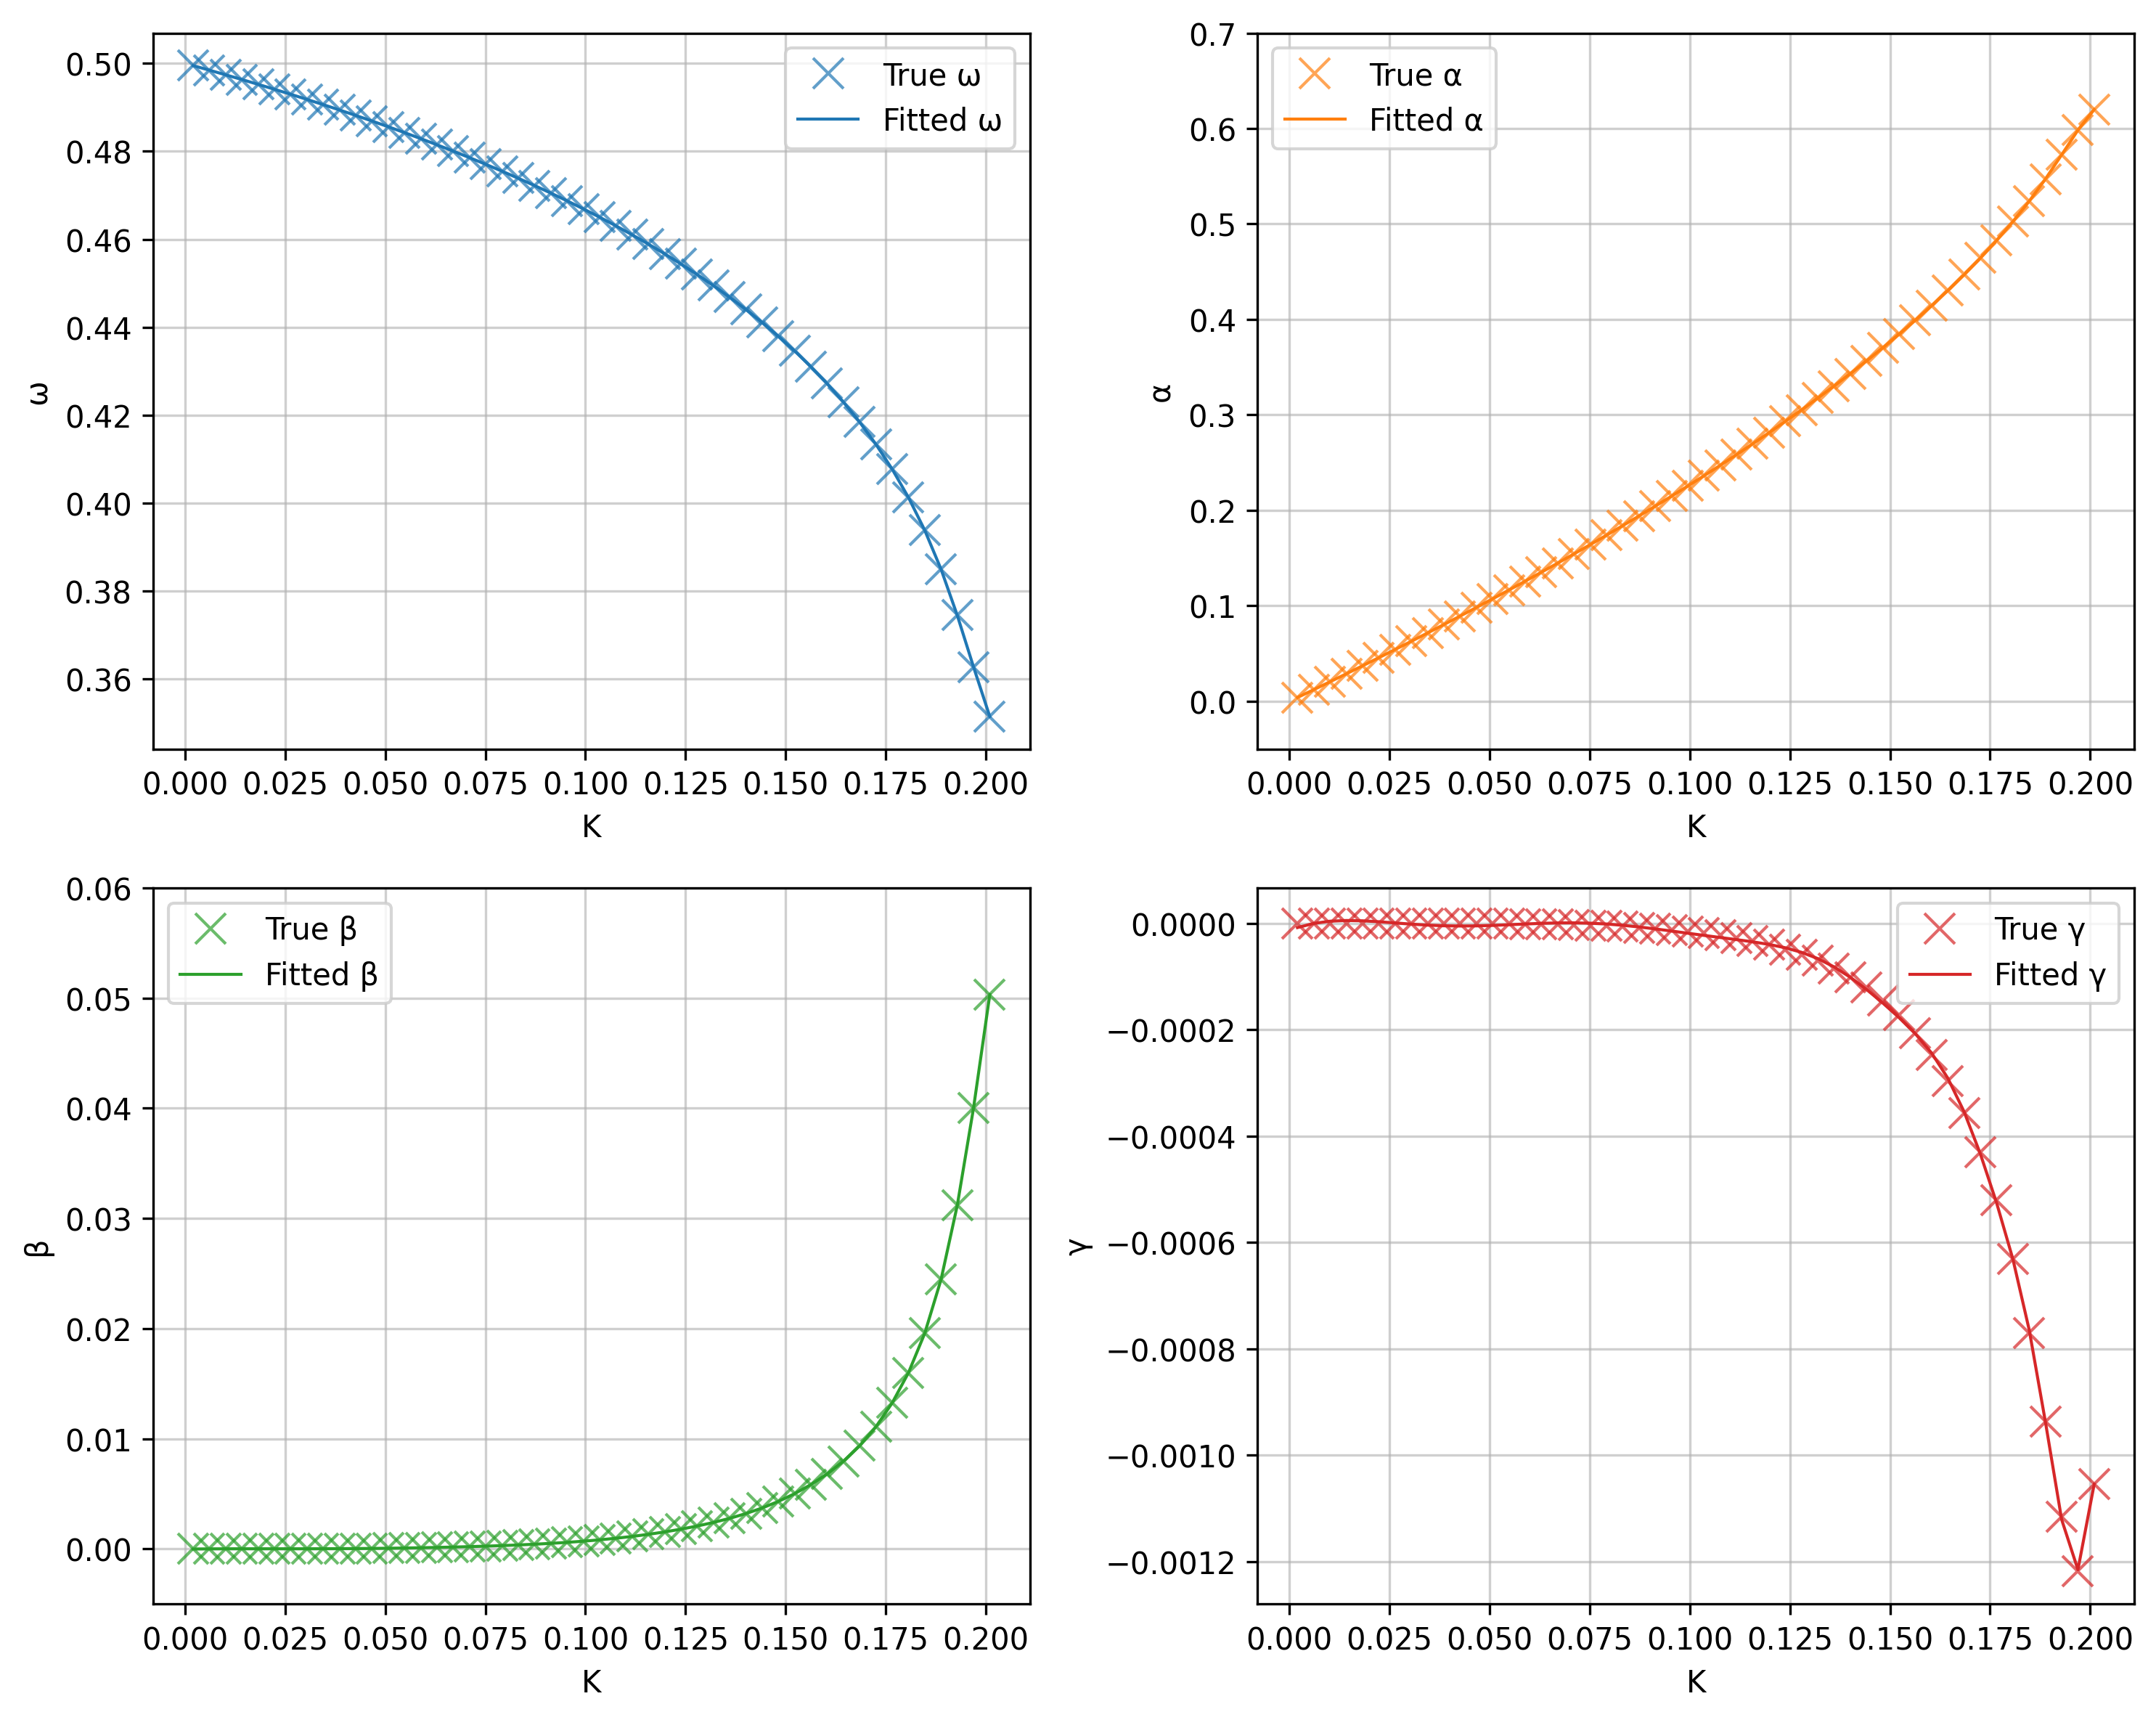


Fitted parameters for the single model predicting [ω, α, β, γ]:
network.0.weight = [[-0.73822785]
 [ 1.19500099]
 [ 0.09552016]
 [ 0.42270612]
 [-1.15533733]
 [ 1.23778773]
 [-0.10825211]
 [ 0.30904758]
 [-0.81454442]
 [-0.54980799]
 [-0.49237707]
 [-0.55790806]
 [-0.07659014]
 [ 0.60556602]
 [ 0.28616954]
 [ 1.41100848]
 [-1.10737037]
 [-0.70900444]
 [ 0.57183312]
 [ 0.49446778]
 [-1.17112821]
 [-0.86717226]
 [-0.94429416]
 [ 0.72506704]
 [-0.53189921]
 [-0.61679866]
 [-0.94515266]
 [-1.82654892]
 [-0.82993146]
 [-0.84459089]
 [-0.8881454 ]
 [ 0.32765034]
 [ 1.41588955]
 [ 1.31734234]
 [ 1.04359613]
 [-0.3102171 ]
 [ 1.319366  ]
 [ 1.31112396]
 [-1.09689036]
 [-0.44863802]
 [ 0.32228236]
 [-1.04131376]
 [-0.43101143]
 [-1.07183376]
 [-0.49738281]
 [ 0.01284519]
 [ 0.06189681]
 [ 1.00676386]
 [ 1.25824198]
 [-1.0089403 ]
 [-0.40728477]
 [ 1.101442  ]
 [ 0.95202611]
 [ 0.87615281]
 [-0.54866939]
 [-1.06327936]
 [ 1.13655892]
 [ 0.21555174]
 [ 0.86070532]
 [-0.58000504]
 [-0.89571247]
 

In [ ]:
plt.figure(figsize=(10, 8), dpi=300)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['ω', 'α', 'β', 'γ']

with torch.no_grad():
    # Single model output for all four parameters
    predictions = model(k_tensor).detach().cpu().numpy()

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.grid(True, alpha=0.6)
    plt.plot(k_values, theta_tensor[:, i].cpu().numpy(), 'x', alpha=0.7,
             label=f'True {labels[i]}', markersize=10, color=colors[i])
    plt.plot(k_values, predictions[:, i], '-',
             color=colors[i], label=f'Fitted {labels[i]}', linewidth=1)
    plt.xlabel('K')
    plt.ylabel(labels[i])
    plt.xlim(min(k_values) - 0.01, max(k_values) + 0.01)
    if i == 1:
        plt.ylim(-0.05, 0.7)
    elif i == 2:
        plt.ylim(-0.005, 0.06)
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig('figs/parameters.pdf', bbox_inches='tight', dpi=300)
plt.show()

print("\nFitted parameters for the single model predicting [ω, α, β, γ]:")
for param_name, param_tensor in model.state_dict().items():
    print(f"{param_name} = {param_tensor.cpu().numpy()}")
print()

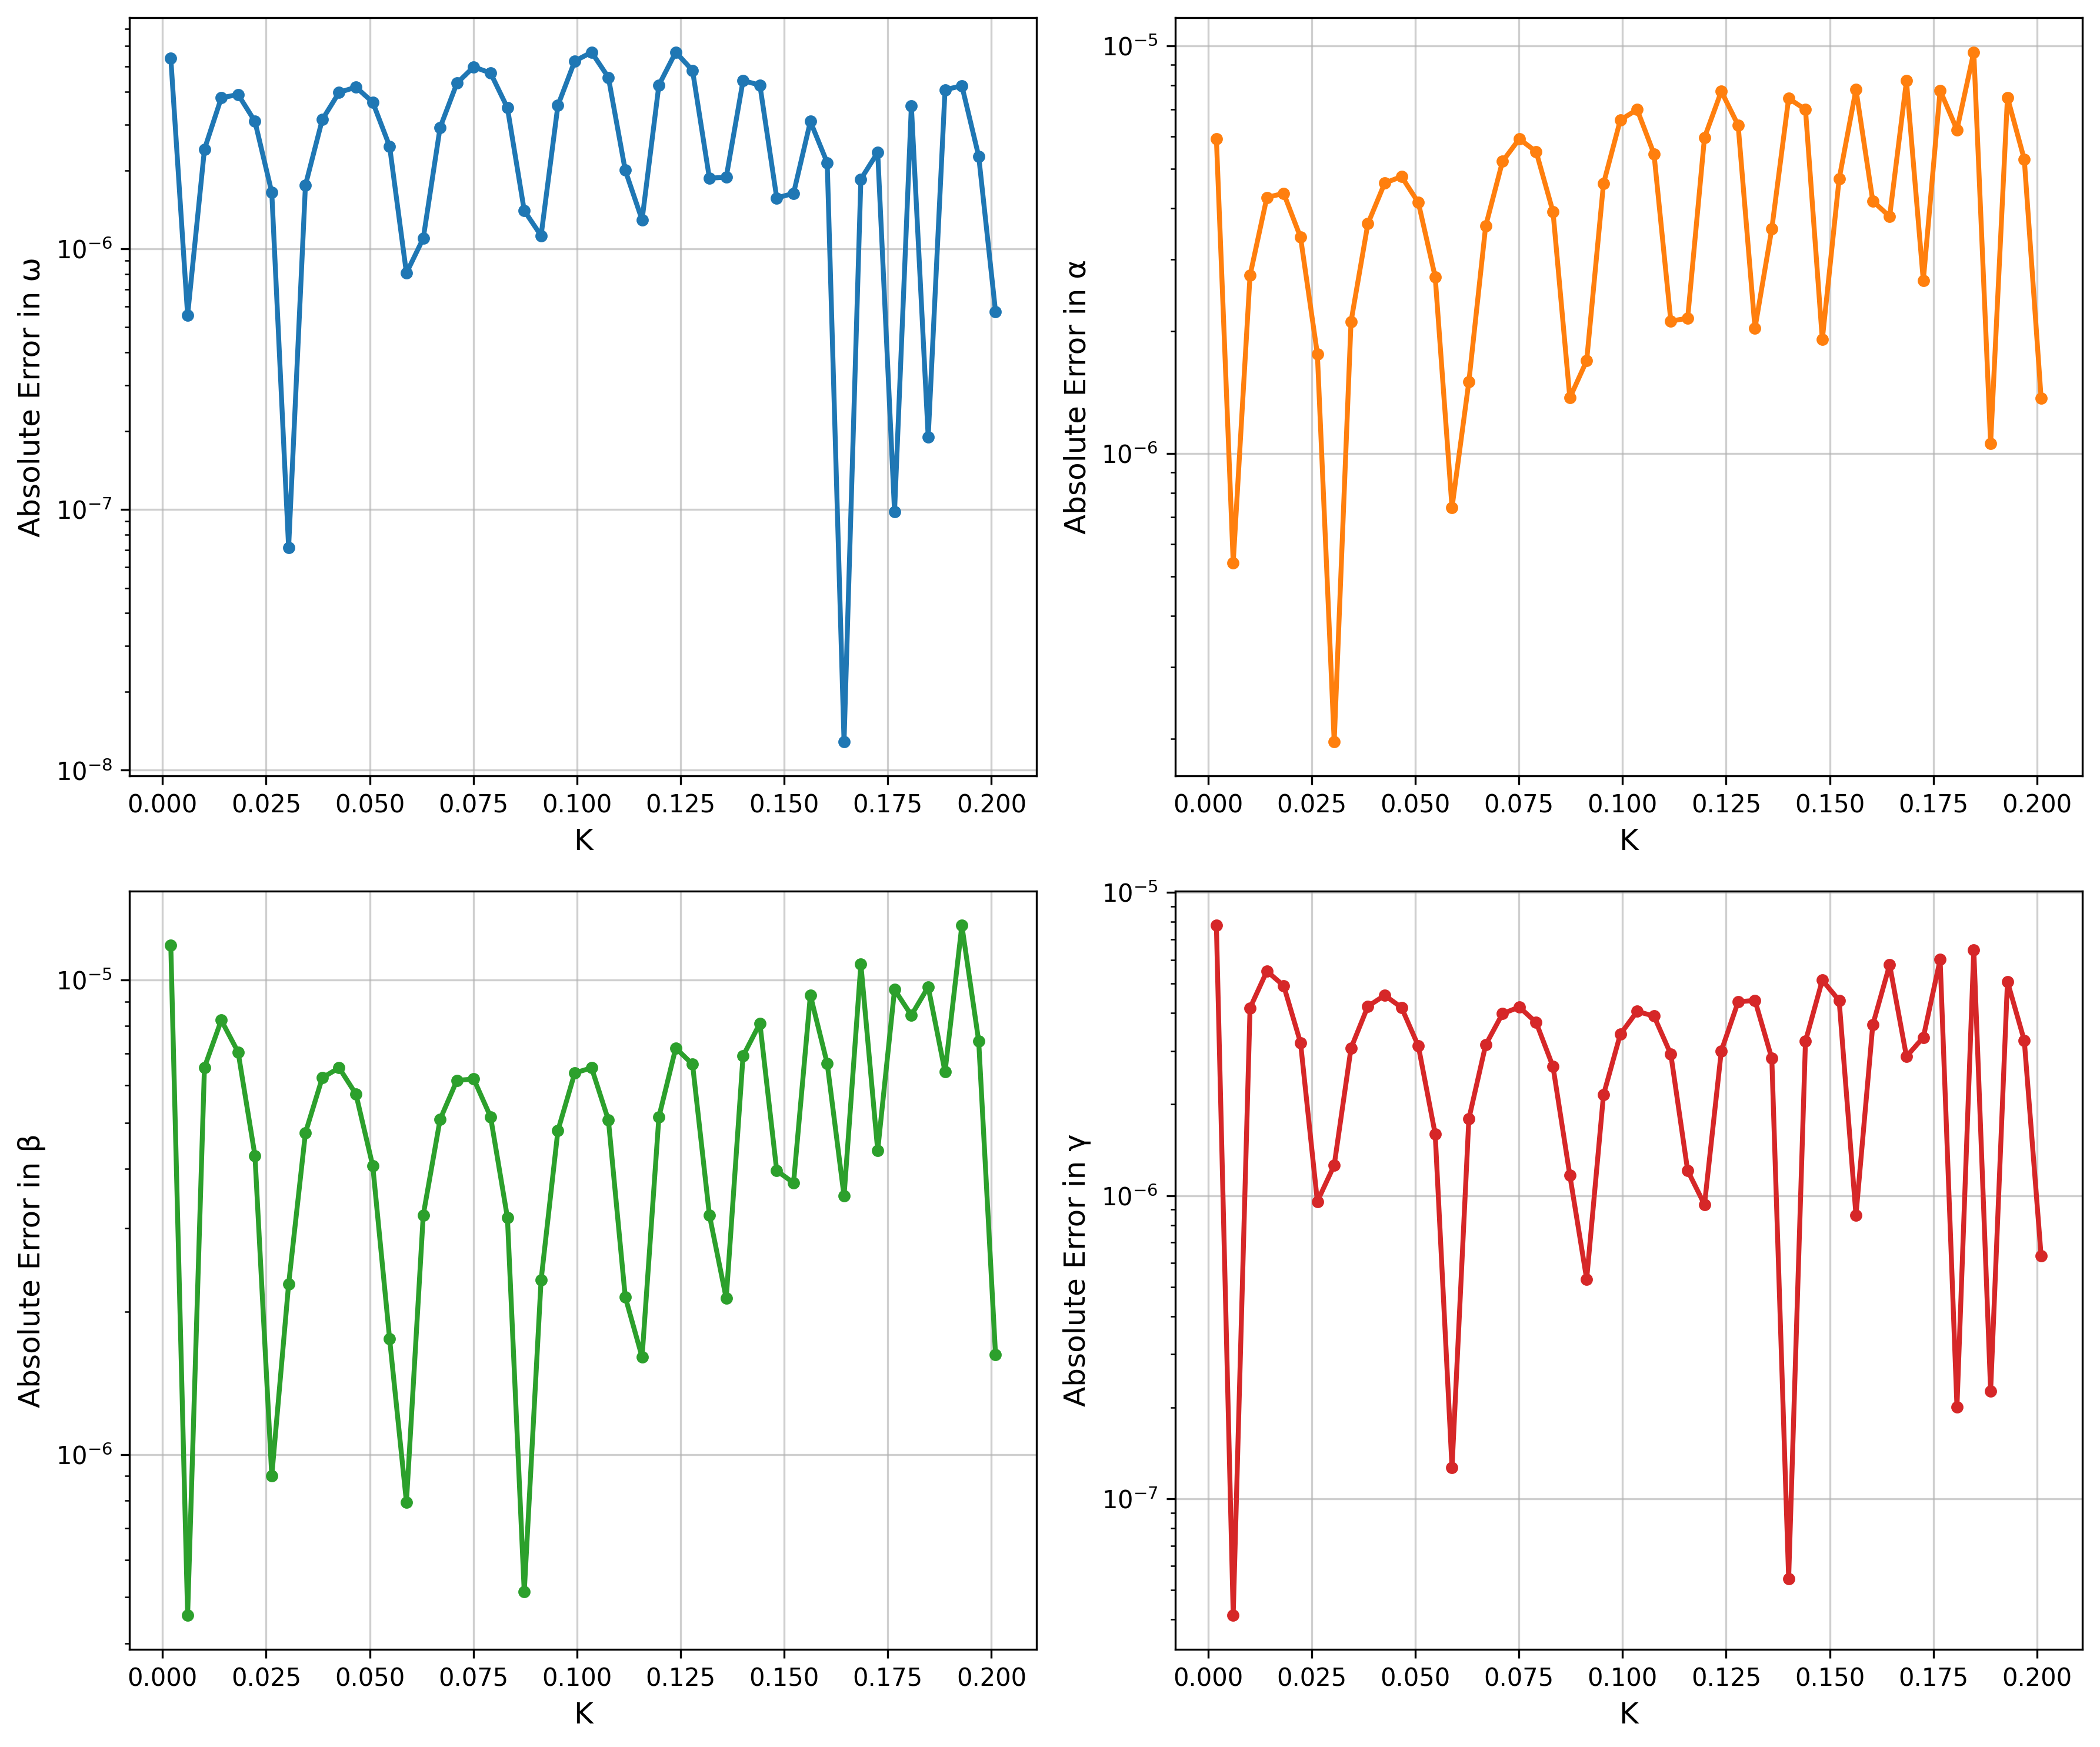

In [ ]:
model.eval()

with torch.no_grad():
    predictions = model(k_tensor)

true_values = theta_tensor.cpu().numpy()
pred_values = predictions.cpu().numpy()

abs_errors = np.abs(true_values - pred_values)

labels = ['ω', 'α', 'β', 'γ']

# Plot errors
plt.figure(figsize=(12, 10), dpi=300)
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.plot(k_values, abs_errors[:, i], 'o-', linewidth=2, markersize=4, color=colors[i])
    plt.xlabel('K', fontsize=12)
    plt.ylabel(f'Absolute Error in {label}', fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.6)

plt.tight_layout()
plt.savefig('figs/absolute_errors.pdf', dpi=300, bbox_inches='tight')
plt.show()